In [5]:
# Loading DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your EEG data
df = pd.read_csv('features_raw.csv')
print(f"Data shape: {df.shape}")
print(f"Channels: {df.columns.tolist()}")

Data shape: (8064, 33)
Channels: ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'Unnamed: 32']


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, n_channels=32, n_timepoints=256, n_classes=2):
        super(EEGNet, self).__init__()
        
        # Conv layer 1: temporal filters
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=16, 
            kernel_size=(1, 15),  # filter across time
            padding=(0, 7)
        )
        self.bn1 = nn.BatchNorm2d(16)
        
        # Conv layer 2: spatial filters across channels
        self.conv2 = nn.Conv2d(
            in_channels=16, 
            out_channels=32, 
            kernel_size=(n_channels, 1)  # filter across channels
        )
        self.bn2 = nn.BatchNorm2d(32)
        
        # Pooling
        self.pool = nn.AvgPool2d(kernel_size=(1, 4))
        
        # Fully connected layer
        self.fc1 = nn.Linear(32 * (n_timepoints // 4), n_classes)

    def forward(self, x):
        # x shape: (batch, 1, channels, timepoints)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # reduce time dimension
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        return x

# Example usage
model = EEGNet(n_channels=32, n_timepoints=256, n_classes=2)
print(model)

# Dummy input: batch of 8 samples, each with 32 channels × 256 timepoints
dummy_input = torch.randn(8, 1, 32, 256)
output = model(dummy_input)


EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(32, 1), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
)
Output shape: torch.Size([8, 2])


Cleaned data shape: (8064, 32)
EEG channels: ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
Categories created: [0 1 2 3]
Category distribution: [6153  528  151 1232]


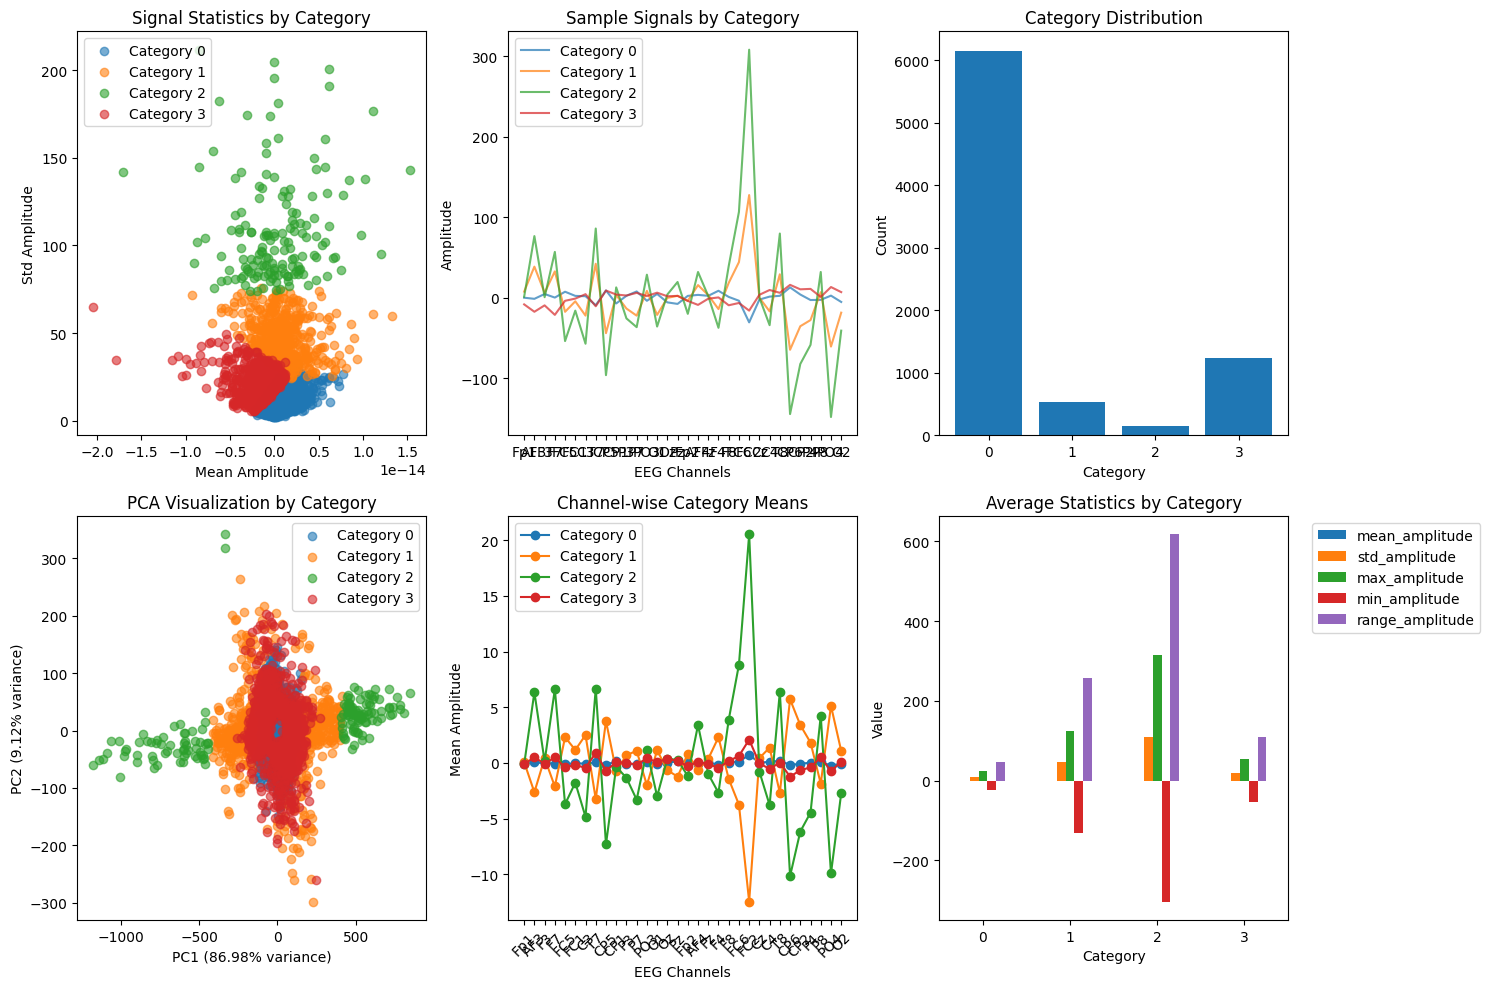


=== Different Categorization Methods ===
Clustering-based categories: [6153  528  151 1232]
Time-based categories: [2016 2016 2016 2016]
Amplitude-based categories: [6153  528  151 1232]

Categorized data saved to 'features_categorized.csv'
New data shape: (8064, 36)


In [2]:
# ... existing code ...

# Data Analysis and Category Creation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and clean the data
df = pd.read_csv('features_raw.csv')

# Remove the empty column
if 'Unnamed: 32' in df.columns:
    df = df.drop('Unnamed: 32', axis=1)

print(f"Cleaned data shape: {df.shape}")
print(f"EEG channels: {df.columns.tolist()}")

# Method 1: Create categories based on signal statistics
def create_signal_categories(df, n_categories=4):
    """Create categories based on signal characteristics"""
    
    # Calculate signal statistics for each sample
    signal_stats = pd.DataFrame({
        'mean_amplitude': df.mean(axis=1),
        'std_amplitude': df.std(axis=1),
        'max_amplitude': df.max(axis=1),
        'min_amplitude': df.min(axis=1),
        'range_amplitude': df.max(axis=1) - df.min(axis=1)
    })
    
    # Use K-means clustering to create categories
    scaler = StandardScaler()
    scaled_stats = scaler.fit_transform(signal_stats)
    
    kmeans = KMeans(n_clusters=n_categories, random_state=42)
    categories = kmeans.fit_predict(scaled_stats)
    
    return categories, signal_stats

# Create categories
categories, signal_stats = create_signal_categories(df, n_categories=4)

# Add categories to dataframe
df['category'] = categories

print(f"Categories created: {np.unique(categories)}")
print(f"Category distribution: {np.bincount(categories)}")

# Visualize the categories
plt.figure(figsize=(15, 10))

# Plot 1: Signal statistics by category
plt.subplot(2, 3, 1)
for cat in range(4):
    mask = categories == cat
    plt.scatter(signal_stats[mask]['mean_amplitude'], 
                signal_stats[mask]['std_amplitude'], 
                label=f'Category {cat}', alpha=0.6)
plt.xlabel('Mean Amplitude')
plt.ylabel('Std Amplitude')
plt.title('Signal Statistics by Category')
plt.legend()

# Plot 2: Sample signals from each category
plt.subplot(2, 3, 2)
for cat in range(4):
    sample_idx = np.where(categories == cat)[0][0]
    plt.plot(df.iloc[sample_idx, :32], label=f'Category {cat}', alpha=0.7)
plt.xlabel('EEG Channels')
plt.ylabel('Amplitude')
plt.title('Sample Signals by Category')
plt.legend()

# Plot 3: Category distribution
plt.subplot(2, 3, 3)
plt.bar(range(4), np.bincount(categories))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution')

# Plot 4: PCA visualization
plt.subplot(2, 3, 4)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df.iloc[:, :32])
for cat in range(4):
    mask = categories == cat
    plt.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                label=f'Category {cat}', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Visualization by Category')
plt.legend()

# Plot 5: Channel-wise category means
plt.subplot(2, 3, 5)
channel_means = df.groupby('category').mean().iloc[:, :32]
for cat in range(4):
    plt.plot(channel_means.columns, channel_means.iloc[cat], 
             label=f'Category {cat}', marker='o')
plt.xlabel('EEG Channels')
plt.ylabel('Mean Amplitude')
plt.title('Channel-wise Category Means')
plt.legend()
plt.xticks(rotation=45)

# Plot 6: Category statistics summary
plt.subplot(2, 3, 6)
stats_by_category = signal_stats.groupby(categories).mean()
stats_by_category.plot(kind='bar', ax=plt.gca())
plt.title('Average Statistics by Category')
plt.xlabel('Category')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Method 2: Time-based segmentation (if data is sequential)
def create_time_based_categories(df, n_segments=4):
    """Create categories based on time segments"""
    n_samples = len(df)
    segment_size = n_samples // n_segments
    categories = []
    
    for i in range(n_samples):
        categories.append(i // segment_size)
    
    return np.array(categories)

# Method 3: Amplitude-based categories
def create_amplitude_categories(df, n_categories=4):
    """Create categories based on overall signal amplitude"""
    mean_amplitude = df.mean(axis=1)
    categories = pd.cut(mean_amplitude, bins=n_categories, labels=range(n_categories))
    return categories.astype(int)

# Show different categorization methods
print("\n=== Different Categorization Methods ===")

# Method 1: Clustering-based (already done above)
print(f"Clustering-based categories: {np.bincount(categories)}")

# Method 2: Time-based
time_categories = create_time_based_categories(df, n_segments=4)
print(f"Time-based categories: {np.bincount(time_categories)}")

# Method 3: Amplitude-based
amplitude_categories = create_amplitude_categories(df, n_categories=4)
print(f"Amplitude-based categories: {np.bincount(amplitude_categories)}")

# Save the categorized data
df_categorized = df.copy()
df_categorized['clustering_category'] = categories
df_categorized['time_category'] = time_categories
df_categorized['amplitude_category'] = amplitude_categories

# Save to new CSV file
df_categorized.to_csv('features_categorized.csv', index=False)
print(f"\nCategorized data saved to 'features_categorized.csv'")
print(f"New data shape: {df_categorized.shape}")